## Plot sections from remapped OTM solution

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
## Suppress warnings related to division by zero
import warnings
warnings.filterwarnings('ignore')
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import gridspec
from tqdm.notebook import tqdm
from scipy.interpolate import griddata

In [2]:
# Load data

OTM_remapped=xr.open_mfdataset('true_remapped.nc')

dC_mix_interp=xr.open_mfdataset('OTM_interp_noprior.nc').dC_mix_interp
dC_OTM_interp=xr.open_mfdataset('OTM_interp_noprior.nc').dC_OTM_interp
dC_change_interp=xr.open_mfdataset('OTM_interp_noprior.nc').dC_change_interp
dC_mix_interp=xr.open_mfdataset('OTM_interp_noprior.nc').dC_mix_interp

# Define basin masks

mask = xr.open_mfdataset('C:/Users/nm455/OneDrive - University of Exeter/UNICORNS/MTM/mask_regular.nc')

lat=OTM_remapped.YC.values.flatten()
lon=OTM_remapped.XC.values.flatten()

lon[np.where(lon<0)]=lon[np.where(lon<0)]+360

(LAT2,LON2)=np.meshgrid(np.arange(-90,90),np.arange(0,360))

# Atlantic

mask_2D=mask.mask.isel(k=0,Basins=[0,1,2,3,8])
mask_2D[4,:,:]=xr.where(np.logical_or(mask.lon>=290,mask.lon<=25),mask_2D[4,:,:],0)

mask_ATL=mask_2D.sum('Basins').expand_dims(dim={'k': mask.k},axis=2)
mask_ATL=xr.where(mask_ATL==0,np.nan,1)

# Pacific

mask_2D=mask.mask.isel(k=0,Basins=[5,6,7,8])
mask_2D[3,:,:]=xr.where(np.logical_and(mask.lon<290,mask.lon>140),mask_2D[3,:,:],0)

mask_PAC=mask_2D.sum('Basins').expand_dims(dim={'k': mask.k},axis=2)
mask_PAC=xr.where(mask_PAC==0,np.nan,1)



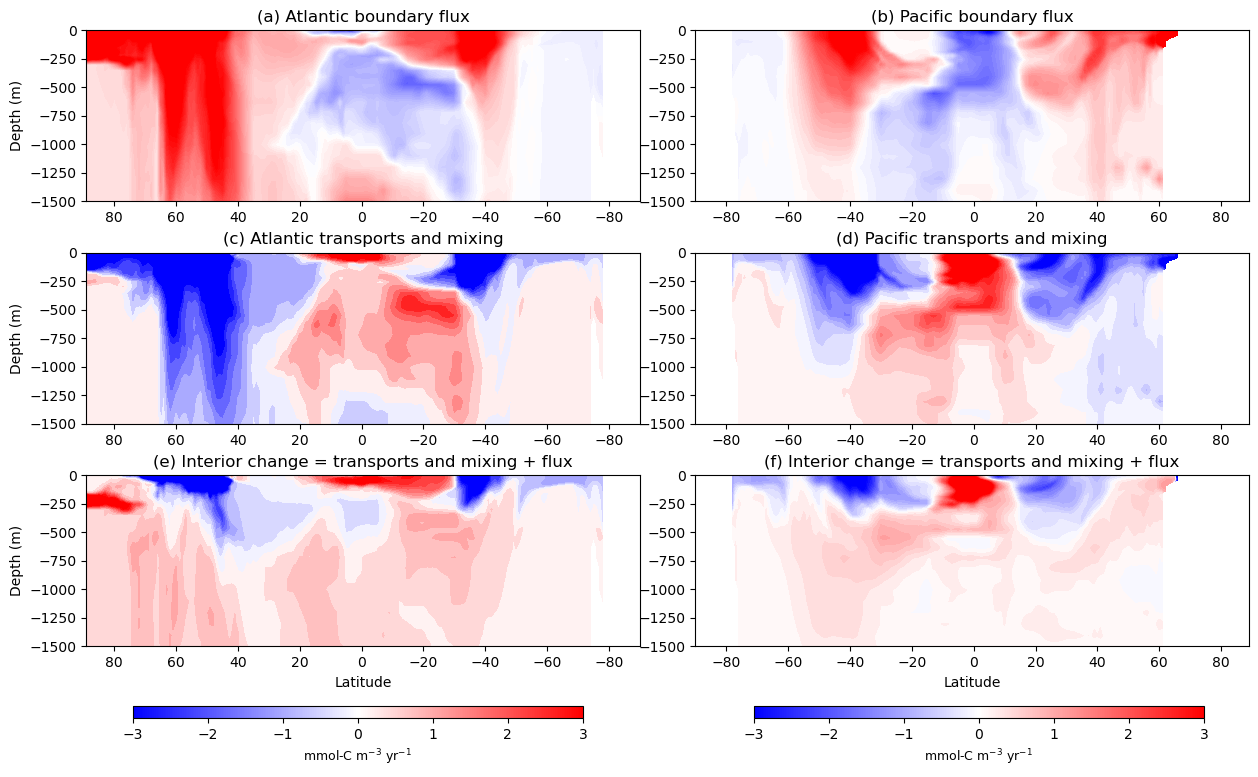

In [3]:
# Plot top 1500 m

fig, axes = plt.subplots(3,2,figsize=(15,8))

plt.subplots_adjust(wspace=0.1, hspace=0.3)

fs=9
ncols=100

minv1, maxv1 = -3, 3
minv2, maxv2 = -3, 3



# Surface flux

axes[0,0].contourf(np.arange(-90,90),OTM_remapped.Z,np.nanmean(dC_OTM_interp*mask_ATL/(OTM_remapped.init_late.values-OTM_remapped.init_early.values),axis=0).transpose(), ncols, vmin=minv1, vmax=maxv1, cmap=plt.cm.bwr)
axes[0,0].set_title('(a) Atlantic boundary flux')
axes[0,0].invert_xaxis()
axes[0,0].set_ylim((-1500,0))

axes[0,1].contourf(np.arange(-90,90),OTM_remapped.Z,np.nanmean(dC_OTM_interp*mask_PAC/(OTM_remapped.init_late.values-OTM_remapped.init_early.values),axis=0).transpose(), ncols, vmin=minv2, vmax=maxv2, cmap=plt.cm.bwr)
axes[0,1].set_title('(b) Pacific boundary flux')
axes[0,1].set_ylim((-1500,0))


# Transports and mixing

axes[1,0].contourf(np.arange(-90,90),OTM_remapped.Z,np.nanmean(dC_mix_interp*mask_ATL/(OTM_remapped.init_late.values-OTM_remapped.init_early.values),axis=0).transpose(), ncols, vmin=minv1, vmax=maxv1, cmap=plt.cm.bwr)
axes[1,0].set_title('(c) Atlantic transports and mixing')
axes[1,0].invert_xaxis()
axes[1,0].set_ylim((-1500,0))

axes[1,1].contourf(np.arange(-90,90),OTM_remapped.Z,np.nanmean(dC_mix_interp*mask_PAC/(OTM_remapped.init_late.values-OTM_remapped.init_early.values),axis=0).transpose(), ncols, vmin=minv2, vmax=maxv2, cmap=plt.cm.bwr)
axes[1,1].set_title('(d) Pacific transports and mixing')
axes[1,1].set_ylim((-1500,0))


# Total change = transports and mixing + surface flux

axes[2,0].contourf(np.arange(-90,90),OTM_remapped.Z,np.nanmean((dC_mix_interp+dC_OTM_interp)*mask_ATL/(OTM_remapped.init_late.values-OTM_remapped.init_early.values),axis=0).transpose(), ncols, vmin=minv1, vmax=maxv1, cmap=plt.cm.bwr)
axes[2,0].set_title('(e) Interior change = transports and mixing + flux')
axes[2,0].invert_xaxis()
axes[2,0].set_ylim((-1500,0))

axes[2,1].contourf(np.arange(-90,90),OTM_remapped.Z,np.nanmean((dC_mix_interp+dC_OTM_interp)*mask_PAC/(OTM_remapped.init_late.values-OTM_remapped.init_early.values),axis=0).transpose(), ncols, vmin=minv2, vmax=maxv2, cmap=plt.cm.bwr)
axes[2,1].set_title('(f) Interior change = transports and mixing + flux')
axes[2,1].set_ylim((-1500,0))

axes[2,0].set_xlabel('Latitude')
axes[2,1].set_xlabel('Latitude')

axes[0,0].set_ylabel('Depth (m)')
axes[1,0].set_ylabel('Depth (m)')
axes[2,0].set_ylabel('Depth (m)')

cax = fig.add_axes([0.156, 0.02, 0.3, 0.015])
m = plt.cm.ScalarMappable(cmap=plt.cm.bwr)
m.set_clim(minv1, maxv1)
cbar = fig.colorbar(m, cax=cax, orientation='horizontal')
cbar.set_label('mmol-C m$^{-3}$ yr$^{-1}$',fontsize=fs)

cax = fig.add_axes([0.570, 0.02, 0.3, 0.015])
m = plt.cm.ScalarMappable(cmap=plt.cm.bwr)
m.set_clim(minv2, maxv2)
cbar = fig.colorbar(m, cax=cax, orientation='horizontal')
cbar.set_label('mmol-C m$^{-3}$ yr$^{-1}$',fontsize=fs)


plt.savefig('sections_1500m_v2.png', bbox_inches='tight', dpi=300, transparent=True)

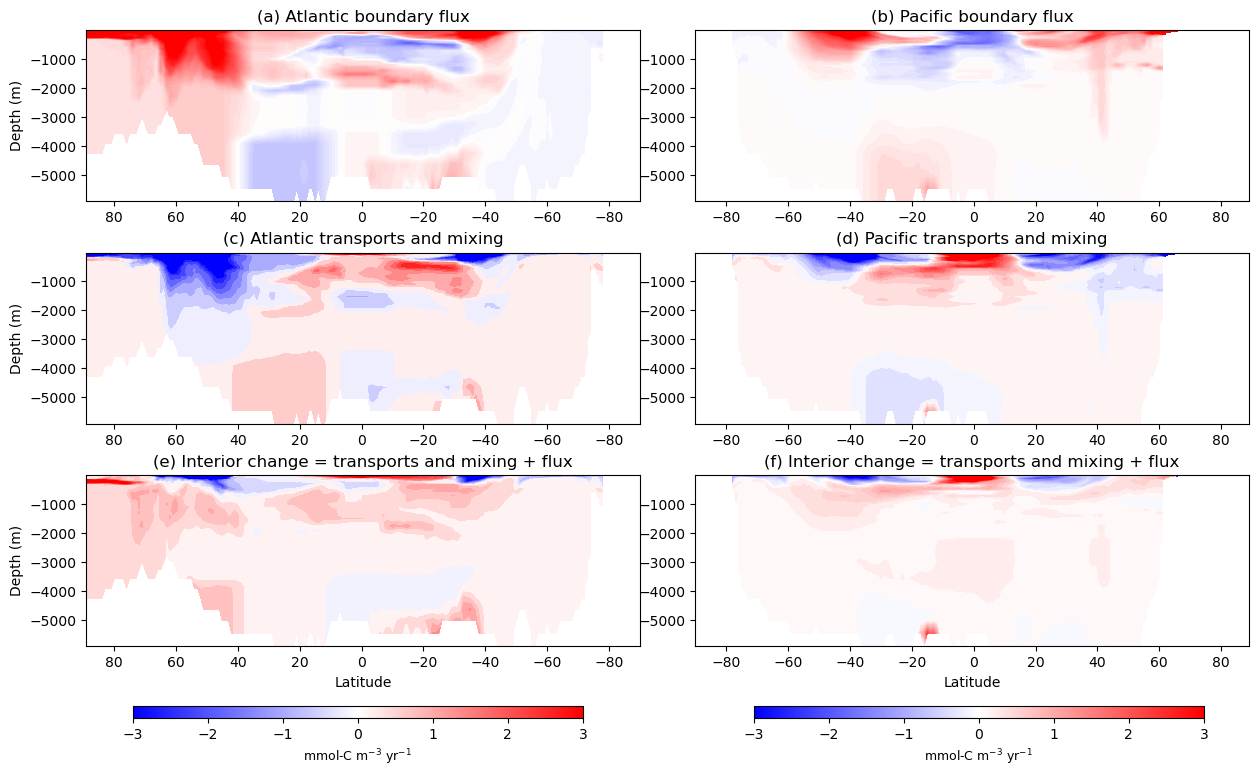

In [4]:
# Plot full depth

fig, axes = plt.subplots(3,2,figsize=(15,8))

plt.subplots_adjust(wspace=0.1, hspace=0.3)

fs=9
ncols=100

minv1, maxv1 = -3, 3
minv2, maxv2 = -3, 3

# Surface flux

axes[0,0].contourf(np.arange(-90,90),OTM_remapped.Z,np.nanmean(dC_OTM_interp*mask_ATL/(OTM_remapped.init_late.values-OTM_remapped.init_early.values),axis=0).transpose(), ncols, vmin=minv1, vmax=maxv1, cmap=plt.cm.bwr)
axes[0,0].set_title('(a) Atlantic boundary flux')
axes[0,0].invert_xaxis()

axes[0,1].contourf(np.arange(-90,90),OTM_remapped.Z,np.nanmean(dC_OTM_interp*mask_PAC/(OTM_remapped.init_late.values-OTM_remapped.init_early.values),axis=0).transpose(), ncols, vmin=minv2, vmax=maxv2, cmap=plt.cm.bwr)
axes[0,1].set_title('(b) Pacific boundary flux')

# Transports and mixing

axes[1,0].contourf(np.arange(-90,90),OTM_remapped.Z,np.nanmean(dC_mix_interp*mask_ATL/(OTM_remapped.init_late.values-OTM_remapped.init_early.values),axis=0).transpose(), ncols, vmin=minv1, vmax=maxv1, cmap=plt.cm.bwr)
axes[1,0].set_title('(c) Atlantic transports and mixing')
axes[1,0].invert_xaxis()

axes[1,1].contourf(np.arange(-90,90),OTM_remapped.Z,np.nanmean(dC_mix_interp*mask_PAC/(OTM_remapped.init_late.values-OTM_remapped.init_early.values),axis=0).transpose(), ncols, vmin=minv2, vmax=maxv2, cmap=plt.cm.bwr)
axes[1,1].set_title('(d) Pacific transports and mixing')


# Total change = transports and mixing + surface flux

axes[2,0].contourf(np.arange(-90,90),OTM_remapped.Z,np.nanmean((dC_mix_interp+dC_OTM_interp)*mask_ATL/(OTM_remapped.init_late.values-OTM_remapped.init_early.values),axis=0).transpose(), ncols, vmin=minv1, vmax=maxv1, cmap=plt.cm.bwr)
axes[2,0].set_title('(e) Interior change = transports and mixing + flux')
axes[2,0].invert_xaxis()

axes[2,1].contourf(np.arange(-90,90),OTM_remapped.Z,np.nanmean((dC_mix_interp+dC_OTM_interp)*mask_PAC/(OTM_remapped.init_late.values-OTM_remapped.init_early.values),axis=0).transpose(), ncols, vmin=minv2, vmax=maxv2, cmap=plt.cm.bwr)
axes[2,1].set_title('(f) Interior change = transports and mixing + flux')


axes[2,0].set_xlabel('Latitude')
axes[2,1].set_xlabel('Latitude')

axes[0,0].set_ylabel('Depth (m)')
axes[1,0].set_ylabel('Depth (m)')
axes[2,0].set_ylabel('Depth (m)')

cax = fig.add_axes([0.156, 0.02, 0.3, 0.015])
m = plt.cm.ScalarMappable(cmap=plt.cm.bwr)
m.set_clim(minv1, maxv1)
cbar = fig.colorbar(m, cax=cax, orientation='horizontal')
cbar.set_label('mmol-C m$^{-3}$ yr$^{-1}$',fontsize=fs)

cax = fig.add_axes([0.570, 0.02, 0.3, 0.015])
m = plt.cm.ScalarMappable(cmap=plt.cm.bwr)
m.set_clim(minv2, maxv2)
cbar = fig.colorbar(m, cax=cax, orientation='horizontal')
cbar.set_label('mmol-C m$^{-3}$ yr$^{-1}$',fontsize=fs)


plt.savefig('sections_fulldepth_v2.png', bbox_inches='tight', dpi=300, transparent=True)

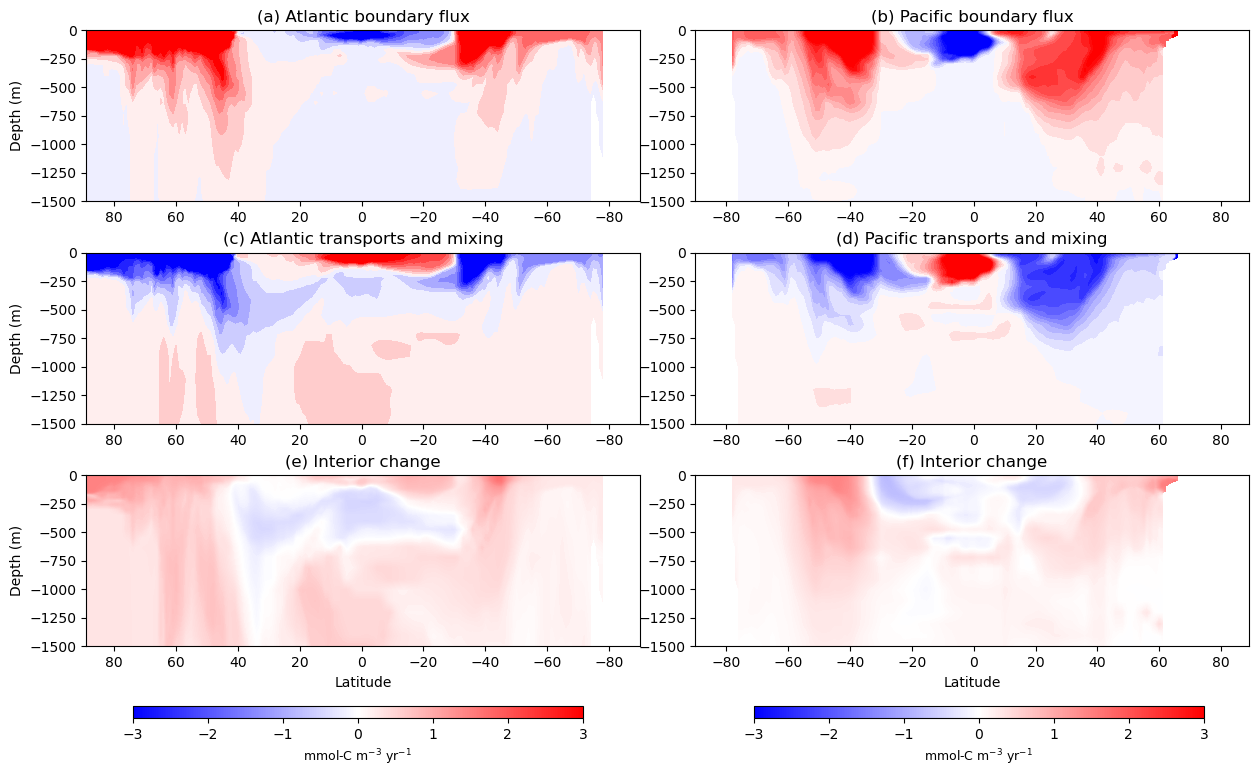

In [5]:
# Plot top 1500m with interior change directly from initial and final C*

fig, axes = plt.subplots(3,2,figsize=(15,8))

plt.subplots_adjust(wspace=0.1, hspace=0.3)

fs=9
ncols=100

minv1, maxv1 = -3, 3
minv2, maxv2 = -3, 3



# Surface flux

axes[0,0].contourf(np.arange(-90,90),OTM_remapped.Z,np.nanmean(dC_OTM_interp*mask_ATL/(OTM_remapped.init_late.values-OTM_remapped.init_early.values),axis=0).transpose(), ncols, vmin=minv1, vmax=maxv1, cmap=plt.cm.bwr)
axes[0,0].set_title('(a) Atlantic boundary flux')
axes[0,0].invert_xaxis()
axes[0,0].set_ylim((-1500,0))

axes[0,1].contourf(np.arange(-90,90),OTM_remapped.Z,np.nanmean(dC_OTM_interp*mask_PAC/(OTM_remapped.init_late.values-OTM_remapped.init_early.values),axis=0).transpose(), ncols, vmin=minv2, vmax=maxv2, cmap=plt.cm.bwr)
axes[0,1].set_title('(b) Pacific boundary flux')
axes[0,1].set_ylim((-1500,0))


# Transports and mixing

axes[1,0].contourf(np.arange(-90,90),OTM_remapped.Z,np.nanmean(dC_mix_interp*mask_ATL/(OTM_remapped.init_late.values-OTM_remapped.init_early.values),axis=0).transpose(), ncols, vmin=minv1, vmax=maxv1, cmap=plt.cm.bwr)
axes[1,0].set_title('(c) Atlantic transports and mixing')
axes[1,0].invert_xaxis()
axes[1,0].set_ylim((-1500,0))

axes[1,1].contourf(np.arange(-90,90),OTM_remapped.Z,np.nanmean(dC_mix_interp*mask_PAC/(OTM_remapped.init_late.values-OTM_remapped.init_early.values),axis=0).transpose(), ncols, vmin=minv2, vmax=maxv2, cmap=plt.cm.bwr)
axes[1,1].set_title('(d) Pacific transports and mixing')
axes[1,1].set_ylim((-1500,0))


# Total change = transports and mixing + surface flux

axes[2,0].contourf(np.arange(-90,90),OTM_remapped.Z,np.nanmean((dC_change_interp)*mask_ATL/(OTM_remapped.init_late.values-OTM_remapped.init_early.values),axis=0).transpose(), ncols, vmin=minv1, vmax=maxv1, cmap=plt.cm.bwr)
axes[2,0].set_title('(e) Interior change')
axes[2,0].invert_xaxis()
axes[2,0].set_ylim((-1500,0))

axes[2,1].contourf(np.arange(-90,90),OTM_remapped.Z,np.nanmean((dC_change_interp)*mask_PAC/(OTM_remapped.init_late.values-OTM_remapped.init_early.values),axis=0).transpose(), ncols, vmin=minv2, vmax=maxv2, cmap=plt.cm.bwr)
axes[2,1].set_title('(f) Interior change')
axes[2,1].set_ylim((-1500,0))

axes[2,0].set_xlabel('Latitude')
axes[2,1].set_xlabel('Latitude')

axes[0,0].set_ylabel('Depth (m)')
axes[1,0].set_ylabel('Depth (m)')
axes[2,0].set_ylabel('Depth (m)')

cax = fig.add_axes([0.156, 0.02, 0.3, 0.015])
m = plt.cm.ScalarMappable(cmap=plt.cm.bwr)
m.set_clim(minv1, maxv1)
cbar = fig.colorbar(m, cax=cax, orientation='horizontal')
cbar.set_label('mmol-C m$^{-3}$ yr$^{-1}$',fontsize=fs)

cax = fig.add_axes([0.570, 0.02, 0.3, 0.015])
m = plt.cm.ScalarMappable(cmap=plt.cm.bwr)
m.set_clim(minv2, maxv2)
cbar = fig.colorbar(m, cax=cax, orientation='horizontal')
cbar.set_label('mmol-C m$^{-3}$ yr$^{-1}$',fontsize=fs)

#plt.savefig('sections_1500m_2.png', bbox_inches='tight', dpi=300, transparent=True)

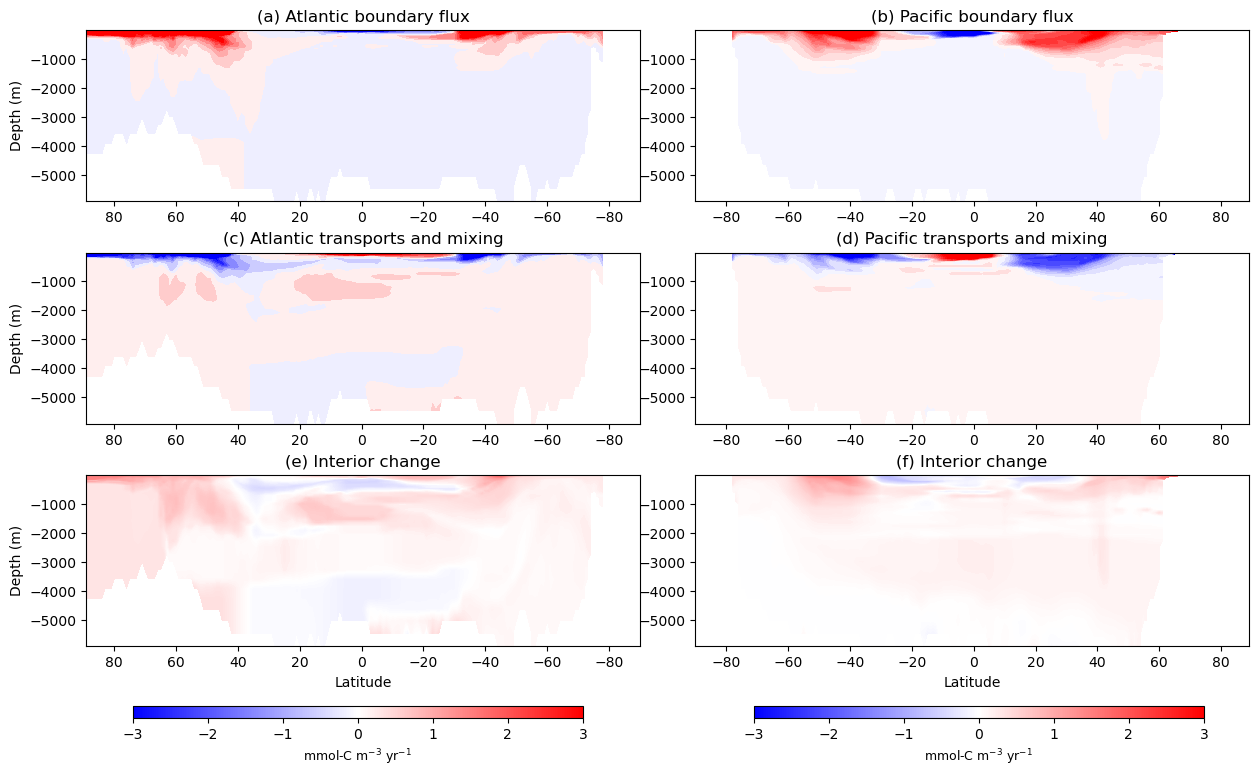

In [6]:
# Plot full depth with interior change directly from initial and final C*

fig, axes = plt.subplots(3,2,figsize=(15,8))

plt.subplots_adjust(wspace=0.1, hspace=0.3)

fs=9
ncols=100

minv1, maxv1 = -3, 3
minv2, maxv2 = -3, 3

# Surface flux

axes[0,0].contourf(np.arange(-90,90),OTM_remapped.Z,np.nanmean(dC_OTM_interp*mask_ATL/(OTM_remapped.init_late.values-OTM_remapped.init_early.values),axis=0).transpose(), ncols, vmin=minv1, vmax=maxv1, cmap=plt.cm.bwr)
axes[0,0].set_title('(a) Atlantic boundary flux')
axes[0,0].invert_xaxis()

axes[0,1].contourf(np.arange(-90,90),OTM_remapped.Z,np.nanmean(dC_OTM_interp*mask_PAC/(OTM_remapped.init_late.values-OTM_remapped.init_early.values),axis=0).transpose(), ncols, vmin=minv2, vmax=maxv2, cmap=plt.cm.bwr)
axes[0,1].set_title('(b) Pacific boundary flux')

# Transports and mixing

axes[1,0].contourf(np.arange(-90,90),OTM_remapped.Z,np.nanmean(dC_mix_interp*mask_ATL/(OTM_remapped.init_late.values-OTM_remapped.init_early.values),axis=0).transpose(), ncols, vmin=minv1, vmax=maxv1, cmap=plt.cm.bwr)
axes[1,0].set_title('(c) Atlantic transports and mixing')
axes[1,0].invert_xaxis()

axes[1,1].contourf(np.arange(-90,90),OTM_remapped.Z,np.nanmean(dC_mix_interp*mask_PAC/(OTM_remapped.init_late.values-OTM_remapped.init_early.values),axis=0).transpose(), ncols, vmin=minv2, vmax=maxv2, cmap=plt.cm.bwr)
axes[1,1].set_title('(d) Pacific transports and mixing')


# Total change = transports and mixing + surface flux

axes[2,0].contourf(np.arange(-90,90),OTM_remapped.Z,np.nanmean((dC_change_interp)*mask_ATL/(OTM_remapped.init_late.values-OTM_remapped.init_early.values),axis=0).transpose(), ncols, vmin=minv1, vmax=maxv1, cmap=plt.cm.bwr)
axes[2,0].set_title('(e) Interior change')
axes[2,0].invert_xaxis()

axes[2,1].contourf(np.arange(-90,90),OTM_remapped.Z,np.nanmean((dC_change_interp)*mask_PAC/(OTM_remapped.init_late.values-OTM_remapped.init_early.values),axis=0).transpose(), ncols, vmin=minv2, vmax=maxv2, cmap=plt.cm.bwr)
axes[2,1].set_title('(f) Interior change')


axes[2,0].set_xlabel('Latitude')
axes[2,1].set_xlabel('Latitude')

axes[0,0].set_ylabel('Depth (m)')
axes[1,0].set_ylabel('Depth (m)')
axes[2,0].set_ylabel('Depth (m)')

cax = fig.add_axes([0.156, 0.02, 0.3, 0.015])
m = plt.cm.ScalarMappable(cmap=plt.cm.bwr)
m.set_clim(minv1, maxv1)
cbar = fig.colorbar(m, cax=cax, orientation='horizontal')
cbar.set_label('mmol-C m$^{-3}$ yr$^{-1}$',fontsize=fs)

cax = fig.add_axes([0.570, 0.02, 0.3, 0.015])
m = plt.cm.ScalarMappable(cmap=plt.cm.bwr)
m.set_clim(minv2, maxv2)
cbar = fig.colorbar(m, cax=cax, orientation='horizontal')
cbar.set_label('mmol-C m$^{-3}$ yr$^{-1}$',fontsize=fs)


#plt.savefig('sections_fulldepth_2.png', bbox_inches='tight', dpi=300, transparent=True)